# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# from sklearn.metrics.pairwise import euclidean_distances

# from sklearn.datasets import make_classification
# from sklearn.datasets import load_iris

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## 1.1 Loading Data

In [2]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas as pd
data = pd.read_csv('preprocessed_data.csv', nrows=50000)
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [3]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [5]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)
x = data.drop(['project_is_approved'], axis=1)
y = data['project_is_approved'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=40, stratify=y)

<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [6]:
feature_name_bow = []
feature_name_tfidf = []

In [7]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
# vectorizer.fit(tqdm(X_train['essay'].values)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.fit_transform(tqdm(X_train['essay'].values))
X_test_essay_bow = vectorizer.transform(tqdm(X_test['essay'].values))

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
# print(vectorizer.get_feature_names())
feature_name_bow.extend(vectorizer.get_feature_names())
print("="*100)

(37500, 8) (37500,)
(12500, 8) (12500,)


100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:08<00:00, 1548.56it/s]


After vectorizations
(37500, 5000) (37500,)
(12500, 5000) (12500,)


In [8]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
# vectorizer.fit(tqdm(X_train['essay'].values)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.fit_transform(tqdm(X_train['essay'].values))
X_test_essay_tfidf = vectorizer.transform(tqdm(X_test['essay'].values))

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
# print(vectorizer.get_feature_names())
feature_name_tfidf.extend(vectorizer.get_feature_names())
print("="*100)

(37500, 8) (37500,)
(12500, 8) (12500,)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:15<00:00, 826.98it/s]


After vectorizations
(37500, 5000) (37500,)
(12500, 5000) (12500,)


In [9]:
print(len(feature_name_bow))
print(len(feature_name_tfidf))

print(feature_name_bow)
print(feature_name_tfidf)

5000
5000
['000', '10', '100', '100 free', '100 percent', '100 students', '100 students receive', '100 students receive free', '11', '12', '12th', '13', '14', '15', '16', '17', '18', '1st', '1st grade', '20', '2016', '2016 2017', '2017', '21', '21st', '21st century', '21st century learners', '21st century skills', '22', '23', '24', '25', '25 students', '26', '28', '2nd', '2nd grade', '2nd graders', '30', '30 students', '3d', '3rd', '3rd grade', '3rd graders', '40', '45', '4th', '4th 5th', '4th grade', '4th graders', '50', '50 students', '500', '5th', '5th grade', '5th grade students', '5th graders', '60', '60 minutes', '60 minutes day', '60 students', '600', '6th', '6th grade', '6th graders', '70', '70 students', '75', '75 students', '7th', '7th 8th', '7th grade', '80', '80 students', '85', '8th', '8th grade', '8th graders', '90', '90 students', '95', '98', '99', '9th', 'abilities', 'ability', 'ability learn', 'ability levels', 'ability move', 'able', 'able access', 'able choose', 'abl

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [10]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.fit_transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_name_bow.extend(vectorizer.get_feature_names())
feature_name_tfidf.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(37500, 51) (37500,)
(12500, 51) (12500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [11]:
print(len(feature_name_bow))
print(len(feature_name_tfidf))

5051
5051


In [12]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.fit_transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_name_bow.extend(vectorizer.get_feature_names())
feature_name_tfidf.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(37500, 5) (37500,)
(12500, 5) (12500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [13]:
print(len(feature_name_bow))
print(len(feature_name_tfidf))

5056
5056


In [14]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.fit_transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_name_bow.extend(vectorizer.get_feature_names())
feature_name_tfidf.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(37500, 4) (37500,)
(12500, 4) (12500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [15]:
print(len(feature_name_bow))
print(len(feature_name_tfidf))

5060
5060


In [16]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_ohe = vectorizer.fit_transform(X_train['clean_categories'].values)
X_test_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_test_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_name_bow.extend(vectorizer.get_feature_names())
feature_name_tfidf.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(37500, 9) (37500,)
(12500, 9) (12500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [17]:
print(len(feature_name_bow))
print(len(feature_name_tfidf))

5069
5069


In [18]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_ohe = vectorizer.fit_transform(X_train['clean_subcategories'].values)
X_test_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_name_bow.extend(vectorizer.get_feature_names())
feature_name_tfidf.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(37500, 30) (37500,)
(12500, 30) (12500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [19]:
print(len(feature_name_bow))
print(len(feature_name_tfidf))

5099
5099


In [20]:
print("\n----------- Original -----------\n")
X_train['price'].values
print(X_train['price'].values.shape)

print("\n----------- reshape(-1,1) -----------\n")
print(X_train['price'].values.reshape(-1,1))
print(X_train['price'].values.reshape(-1,1).shape)

print("\n----------- reshape(1,-1) -----------\n")
print(X_train['price'].values.reshape(1,-1))
print(X_train['price'].values.reshape(1,-1).shape)


----------- Original -----------

(37500,)

----------- reshape(-1,1) -----------

[[660.97]
 [250.91]
 [ 57.88]
 ...
 [149.65]
 [467.09]
 [349.99]]
(37500, 1)

----------- reshape(1,-1) -----------

[[660.97 250.91  57.88 ... 149.65 467.09 349.99]]
(1, 37500)


In [21]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(1,-1)).T
X_test_price_norm = normalizer.fit_transform(X_test['price'].values.reshape(1,-1)).T



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(37500, 1) (37500,)
(12500, 1) (12500,)


In [22]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_approv_project_norm = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).T
X_test_prev_approv_project_norm = normalizer.fit_transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).T



print("After vectorizations")
print(X_train_prev_approv_project_norm.shape, y_train.shape)
print(X_test_prev_approv_project_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(37500, 1) (37500,)
(12500, 1) (12500,)


In [23]:
feature_name_bow.extend(['price','prev_approv_proj'])
feature_name_tfidf.extend(['price','prev_approv_proj'])

print(len(feature_name_bow))
print(len(feature_name_tfidf))

print(feature_name_bow[5000:])
# print(feature_name_tfidf[5000:])

5101
5101
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy', 'dr', 'mr', 'mrs', 'ms', 'teacher', 'grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2', 'appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth', 'appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performing

In [24]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_prev_approv_project_norm)).tocsr()
X_te_bow = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_price_norm, X_test_prev_approv_project_norm)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_te_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(37500, 5101) (37500,)
(12500, 5101) (12500,)


In [25]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_prev_approv_project_norm)).tocsr()
X_te_tfidf = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_price_norm, X_test_prev_approv_project_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(37500, 5101) (37500,)
(12500, 5101) (12500,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

In [26]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
from sklearn.model_selection import RandomizedSearchCV

neigh = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf_bow = RandomizedSearchCV(neigh, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf_tfidf = RandomizedSearchCV(neigh, parameters, cv=3, scoring='roc_auc', return_train_score=True)

clf_bow.fit(X_tr_bow, y_train)
clf_tfidf.fit(X_tr_tfidf, y_train)

results_bow = pd.DataFrame.from_dict(clf_bow.cv_results_)
results_tfidf = pd.DataFrame.from_dict(clf_tfidf.cv_results_)

# print(results_bow.head(10))
# print(results_tfidf.head(10))

results_bow = results_bow.sort_values(['param_alpha'])
results_tfidf = results_tfidf.sort_values(['param_alpha'])


train_auc_bow, train_auc_tfidf = results_bow['mean_train_score'], results_tfidf['mean_train_score']
cv_auc_bow, cv_auc_tfidf = results_bow['mean_test_score'], results_tfidf['mean_test_score']
alpha_bow, alpha_tfidf =  results_bow['param_alpha'], results_tfidf['param_alpha']


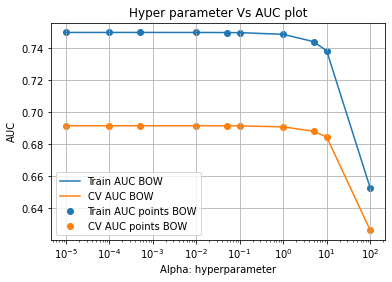

In [27]:
plt.plot(alpha_bow, train_auc_bow, label='Train AUC BOW')
plt.plot(alpha_bow, cv_auc_bow, label='CV AUC BOW')

plt.scatter(alpha_bow, train_auc_bow, label='Train AUC points BOW')
plt.scatter(alpha_bow, cv_auc_bow, label='CV AUC points BOW')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.xscale('log')
plt.show()

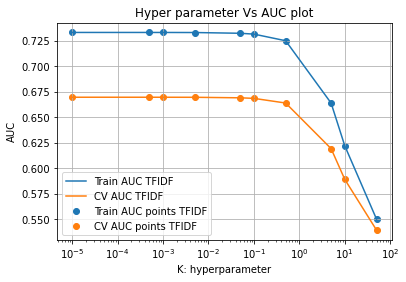

In [28]:
plt.plot(alpha_tfidf, train_auc_tfidf, label='Train AUC TFIDF')
plt.plot(alpha_tfidf, cv_auc_tfidf, label='CV AUC TFIDF')


plt.scatter(alpha_tfidf, train_auc_tfidf, label='Train AUC points TFIDF')
plt.scatter(alpha_tfidf, cv_auc_tfidf, label='CV AUC points TFIDF')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.xscale('log')
plt.show()

In [29]:
print(results_bow.head(10))
print('-------------------------------------------------------------------------')
print(results_tfidf.head(10))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
4       0.101063      0.001244         0.028282    4.551373e-04     0.00001   
5       0.103390      0.001244         0.027926    6.257699e-07      0.0001   
6       0.114412      0.013266         0.024082    2.718444e-03      0.0005   
9       0.104056      0.000940         0.029589    4.704712e-04        0.01   
8       0.104388      0.001245         0.029257    4.696848e-04        0.05   
0       0.101396      0.000941         0.028591    9.400996e-04         0.1   
7       0.103723      0.001411         0.028590    4.697408e-04           1   
3       0.101063      0.000941         0.027927    8.141987e-04           5   
1       0.101063      0.001244         0.027925    7.018853e-07          10   
2       0.100398      0.000941         0.027261    4.698560e-04         100   

              params  split0_test_score  split1_test_score  split2_test_score  \
4   {'alpha': 1e-05}           0.694944          

In [30]:
print(X_tr_bow.shape)
print(y_train.shape)

(37500, 5101)
(37500,)


In [31]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.


In [32]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


#### Set 2

In [33]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot



In [34]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.


In [35]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.


In [36]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


In [37]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)



<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [38]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/